## One Pixel Attack Demo

Here, we attempt to implement the one pixel attack ourselves in order to make a .gif to demonstrate the one pixel attack in the presentation.
However, the differential evolution algorithm is borrowed from the original authors of the one pixel attack.
Please look at 'differential_evolution.py' for more infomation.
The helper function 'helper.py' is also borrowed from them. The helper function simply allow us to plot and visualise the image easily.

We will implement the attack on our trained CIFAR10 model. The class file to load our model is again, adapted from the original authors.

(This program doesn't produce the .gif. Rather, we saved individual images and used an online .gif making service.)

In [1]:
import numpy as np
import matplotlib
import keras
from keras.datasets import cifar10

# This is our class to load our CIFAR10 CNN model.
from loadcifar10 import MyCIFAR10

# This two functions are from the original authors of the one pixel attack.
from differential_evolution import differential_evolution
import helper

Using TensorFlow backend.


In [2]:
# Load dataset and our CIFAR10 model.
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
model = MyCIFAR10()

Successfully loaded mycifar10


In [3]:
def onepixel_attack(image_index, model, maxiter=75, popsize=400):
    """Implement the one pixel attack and plot the attacked image.
       
    1.) Get the differential evolution function to calculate the attack vectors.
    2.) Perturb the image with the attack vectors.
    3.) Classify/predict the perturbed image.
    4.) Plot perturbed image, predicted class and actual class.
    """

    # The true class of the image.
    actual_class = y_test[image_index, 0]
    
    # These are parameters needed by the differential evolution function.
    # Bounds for x,y and r,g,b. (32 pixels for CIFAR10)
    bounds = [(0, 32), (0, 32), (0, 256), (0, 256), (0, 256)]
    # Population multiplier
    popmul = max(1, popsize // len(bounds))
    
    # We have to define predict_class in this way for differential evolution function to accept it.
    def predict_fn(vecs):
        return predict_classes(vecs, x_test[image_index], actual_class, model)

    # Differential evolution
    attack_result = differential_evolution(predict_fn, bounds, maxiter=maxiter, popsize=popmul,
                                           recombination=1, atol=-1, polish=False)

    # Perturb image based on the attack calculated by differential evolution
    attack_image = perturb_image(attack_result.x, x_test[image_index])[0]

    # Predict the perturbed image and find the predicted class.
    predicted_probs = model.predict_one(attack_image)
    predicted_class = np.argmax(predicted_probs)

    # Plot the perturbed image.
    helper.plot_image(attack_image, actual_class, class_names, predicted_class)


def predict_classes(vecs, image, actual_class, model):
    """Simple function that returns the predictions of the perturbed image."""

    # Perturb the image.
    images_perturbed = perturb_image(vecs, image)

    # Predict the class.
    predictions = model.predict(images_perturbed)[:, actual_class]

    return predictions


def perturb_image(vecs, image):
    """Perturb the image based on the attack vector vecs."""

    # Put vecs in an array if its not already in an array.
    if vecs.ndim < 2:
        vecs = np.array([vecs])

    # Tile the image len(vecs) number of times.
    tile = [len(vecs)] + [1] * (vecs.ndim + 1)
    images = np.tile(image, tile)
    
    # vecs is floored as int.
    vecs = vecs.astype(int)
    
    for vec, image in zip(vecs, images):
        # Split vec into groups of 5 elements -> (x, y, r, g, b).
        pixels = np.split(vec, len(vec) // 5)

        # At each pixel's x, y position, assign its rgb value
        for pixel in pixels:
            x_pos, y_pos, *rgb = pixel
            image[x_pos, y_pos] = rgb
    
    return images

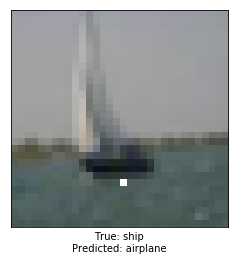

In [4]:
# Turns out our model is robust against one pixel attack.
# Image 55 happens to be one of the images that can be attacked.
onepixel_attack(55, model, maxiter=20);